# VGGT Model

In [ ]:
# Installs
!pip install rasterio

In [ ]:
# Import libraries
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
import torch
from google.colab import drive
from vggt.utils.load_fn_tif import load_and_preprocess_geotiff # Certifique-se que este utilitário está acessível

## Env set up

In [ ]:
# This line imports the drive module from the google.colab library
# from google.colab import drive
# This command initiates the process of connecting your Google Drive to the Colab notebook's file system.
# When you execute this line, you will likely be prompted to authorize Colab to access your Google Drive.
# Once authorized, your Google Drive will become accessible within the Colab environment at the specified path
# drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks


In [ ]:
# Change location to vggt folder
%cd /content/drive/MyDrive/Colab Notebooks/vggt

/content/drive/MyDrive/Colab Notebooks/vggt


In [ ]:
# Clone vggt model and create vggt folder in my drive
# if not os.path.exists("vggt"):
#  !git clone https://github.com/facebookresearch/vggt.git

## Training

In [ ]:
# !pip install -e .

Obtaining file:///content/drive/MyDrive/Colab%20Notebooks/vggt
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for vggt (pyproject.toml) ... done
  Created wheel for vggt: filename=vggt-0.0.1-0.editable-py3-none-any.whl size=9425 sha256=34915f7b50e12ae87ea0f56601514cedba8b414da6936ba2dababf0d8f1635b2
  Stored in directory: /tmp/pip-ephem-wheel-cache-x0_5tf3l/wheels/2a/2d/63/dabc6e1ece6e1beab946dc29cc38e25862e5cda50100e59d46
Successfully built vggt
  Attempting uninstall: vggt
    Found existing installation: vggt 0.0.1
    Uninstalling vggt-0.0.1:
      Successfully uninstalled vggt-0.0.1


In [ ]:
from vggt.models.vggt import VGGT
# Configuração do dispositivo e precisão
device = "cuda" if torch.cuda.is_available() else "cpu"
dtype = torch.bfloat16 if torch.cuda.get_device_capability()[0] >= 8 else torch.float16

# Carrega modelo pré-treinado
model = VGGT.from_pretrained("facebook/VGGT-1B").to(device)
model.eval()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/5.03G [00:00<?, ?B/s]

VGGT(
  (aggregator): Aggregator(
    (patch_embed): DinoVisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
        (norm): Identity()
      )
      (blocks): ModuleList(
        (0-23): 24 x NestedTensorBlock(
          (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (attn): MemEffAttention(
            (qkv): Linear(in_features=1024, out_features=3072, bias=True)
            (q_norm): Identity()
            (k_norm): Identity()
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=1024, out_features=1024, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): LayerScale()
          (drop_path1): Identity()
          (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=1024, out_features=4096, bias=True)
            (act): GELU(approximate=

## Predictions

In [ ]:
# Load all GeoTIFFs from input_data folder
folder_path = '/content/drive/MyDrive/Colab Notebooks/vggt/input_data'

# Inicializa a lista
image_names = []

# Percorre os arquivos da pasta
for file_name in os.listdir(folder_path):
    if file_name.lower().endswith(".tif"):
        # Adiciona o caminho completo do arquivo à lista
        image_names.append(os.path.join(folder_path, file_name))

image_names

['/content/drive/MyDrive/Colab Notebooks/vggt/input_data/11.tif',
 '/content/drive/MyDrive/Colab Notebooks/vggt/input_data/10.tif',
 '/content/drive/MyDrive/Colab Notebooks/vggt/input_data/12.tif']

In [ ]:
images, meta_list = load_and_preprocess_geotiff(image_names, mode="crop")
images = images.to(device)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 105.8 MB/s eta 0:00:00


In [ ]:
# Run inference with the model
with torch.no_grad():
    with torch.amp.autocast(device_type="cuda", dtype=dtype):
        predictions = model(images)
        depth_map = predictions['depth'][0, 0].cpu()

/content/drive/MyDrive/Colab Notebooks/vggt/vggt/models/vggt.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


In [ ]:
# Convert depth map to NumPy array
depth_map_np = depth_map.numpy()
depth_map_np = np.squeeze(depth_map_np)

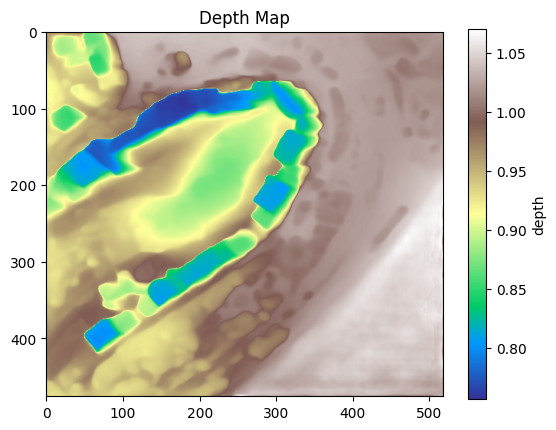

In [ ]:
# Visualize the result
plt.imshow(depth_map, cmap='terrain')
plt.colorbar(label='depth')
plt.title("Depth Map")
plt.show()